In [1]:
machine = 'local'
#macine = 'colab'

In [2]:
if machine == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("archive.zip", 'r')
zip_ref.extractall("./content/dataset")
zip_ref.close()

In [4]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

2024-11-06 11:23:10.199719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730888590.267536    1741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730888590.288765    1741 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 11:23:10.471093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train_path = './content/dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path)
for directory in directories:
    f_path = os.path.join(train_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

print(train_frame.shape)

(5712, 2)


In [6]:
test_path = './content/dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path)
for directory in directories:
    f_path = os.path.join(test_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

print(test_frame.shape)

(1311, 2)


In [7]:
train, valid = train_test_split(train_frame, train_size=0.9, shuffle=True, random_state=42)

print(train.shape)
print(valid.shape)

(5140, 2)
(572, 2)


In [8]:
np.unique(train.label,return_counts=True)


(array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype=object),
 array([1196, 1213, 1439, 1292]))

In [9]:
img_size = (224, 224)
batch_size = 16
tr_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.02,
                            height_shift_range=0.02,
                            horizontal_flip=True)

ts_gen= ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train, x_col = 'filepaths', y_col = 'label', target_size = img_size,
                                      class_mode = 'categorical', color_mode = 'rgb', shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, x_col = 'filepaths', y_col = 'label', target_size = img_size,
                                       class_mode = 'categorical', color_mode = 'rgb', shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_frame, x_col= 'filepaths', y_col = 'label', target_size = img_size,
                                      class_mode = 'categorical', color_mode= 'rgb', shuffle = False, batch_size = batch_size)



Found 5140 validated image filenames belonging to 4 classes.
Found 572 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [10]:
print(np.shape(train_gen[0][0]))

(16, 224, 224, 3)


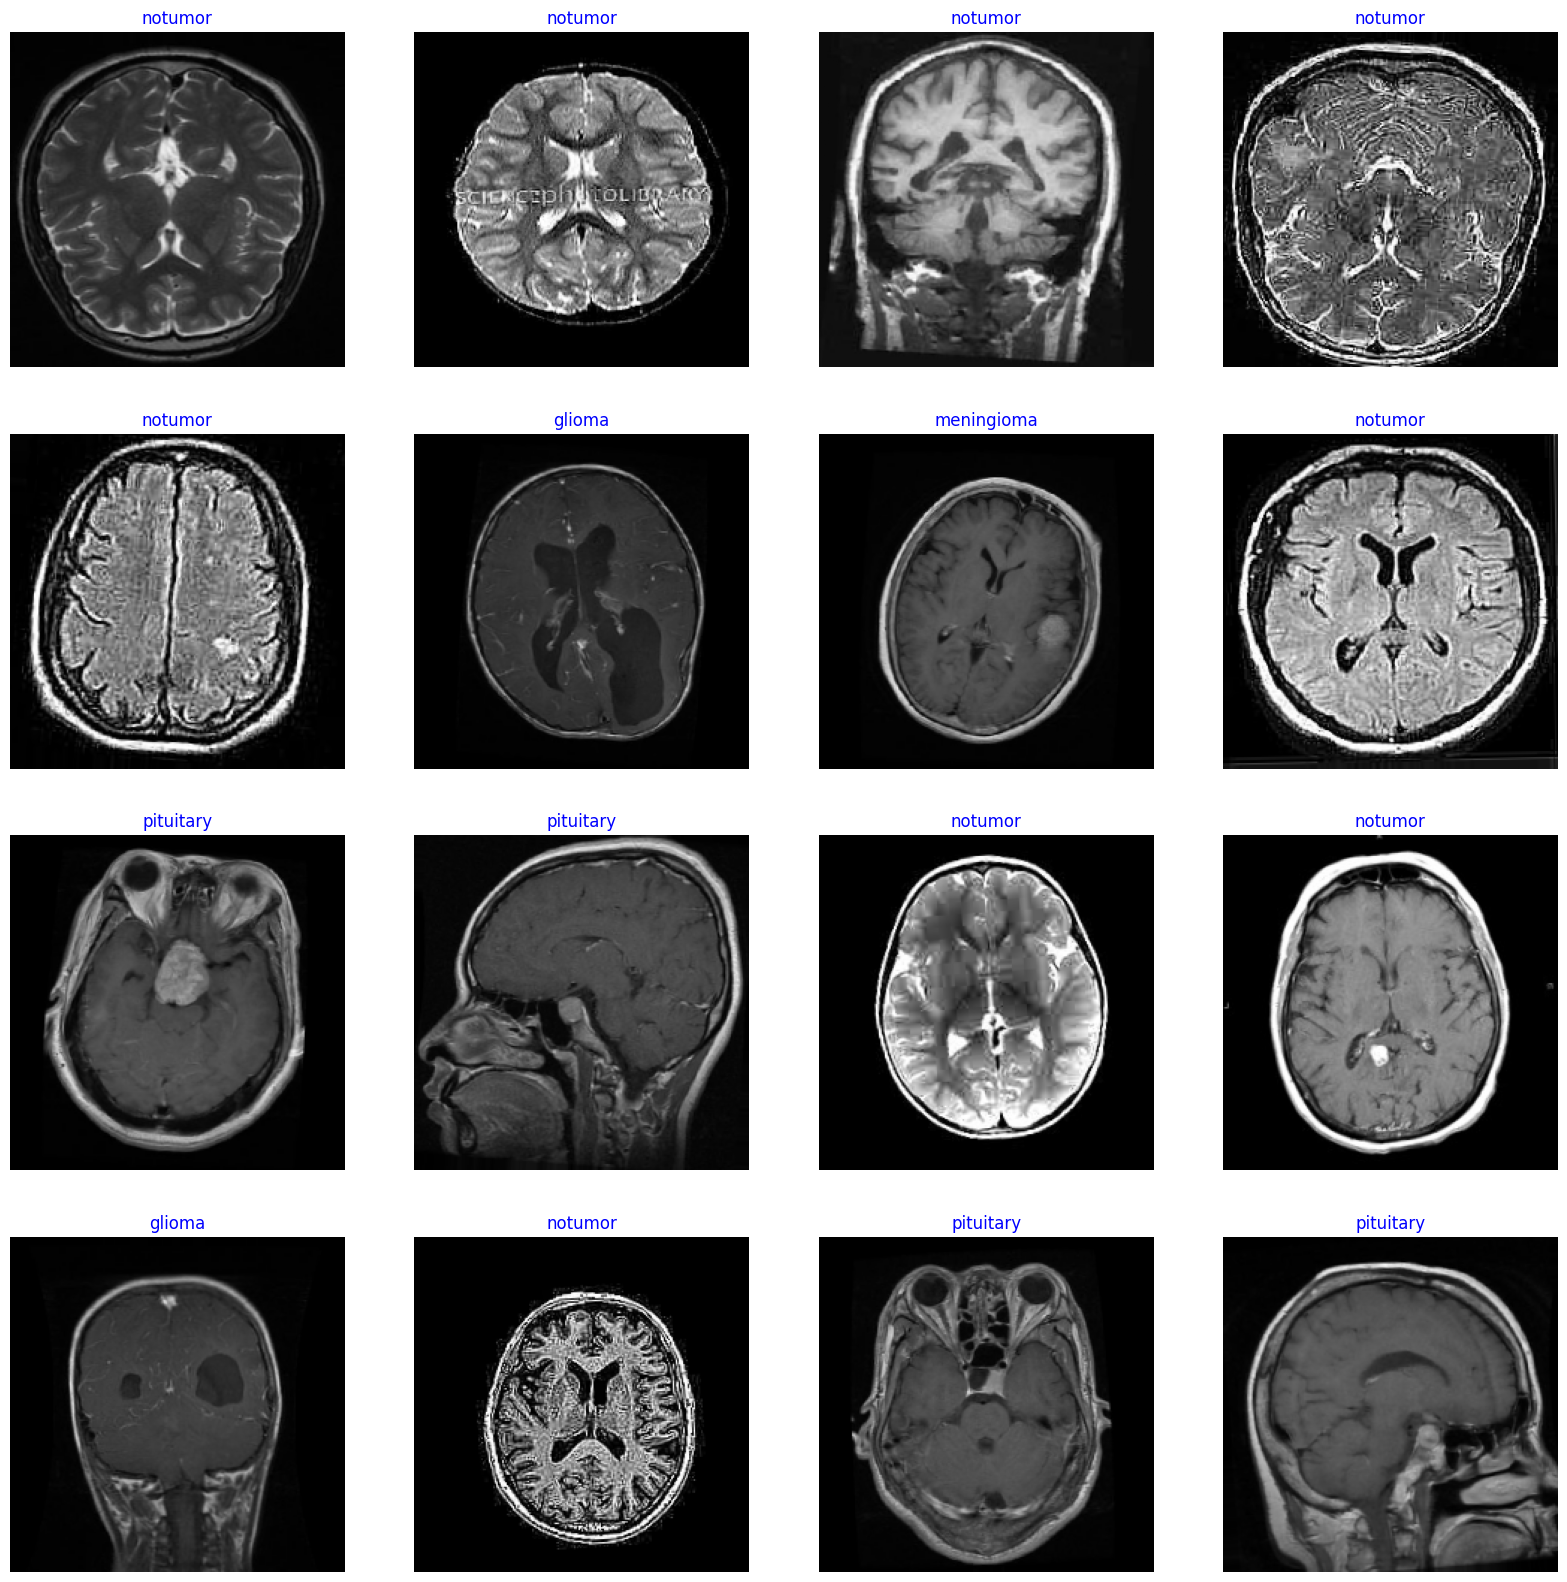

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        image = images[i]
        ax.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        ax.set_title(class_name, color='blue', fontsize=12)
        ax.axis('off')
    else:
        break

plt.show()

In [19]:
## img_shape = (224, 224, 3)

base_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)
   
model = Sequential(
    [base_model,
    Flatten(),
    Dense(4, activation='softmax')]
)

model.compile(
    optimizer=Adamax(learning_rate=0.001) ,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
    
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Epochs = 12

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         7,684 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,329,668 (69.92 MB)

 Trainable params: 18,100,612 (69.05 MB)

 Non-trainable params: 229,056 (894.75 KB)

Epoch 1/12


2024-11-06 12:05:27.136409: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'loop_add_maximum_multiply_reduce_subtract_fusion_32', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_2', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_325', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_328', 8 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_329', 4 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_473', 4 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in fun

321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8065 - loss: 0.9629

2024-11-06 12:15:33.693103: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_32', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_37', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_27', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_144', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_173', 8 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_176', 4 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function

322/322 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - accuracy: 0.8069 - loss: 0.9603 - val_accuracy: 0.7797 - val_loss: 1.2431
Epoch 2/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 99s 307ms/step - accuracy: 0.9488 - loss: 0.1726 - val_accuracy: 0.9510 - val_loss: 0.1605
Epoch 3/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 99s 307ms/step - accuracy: 0.9586 - loss: 0.1461 - val_accuracy: 0.9685 - val_loss: 0.1153
Epoch 4/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 94s 292ms/step - accuracy: 0.9650 - loss: 0.1161 - val_accuracy: 0.9091 - val_loss: 0.3452
Epoch 5/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 299ms/step - accuracy: 0.9694 - loss: 0.1065 - val_accuracy: 0.9406 - val_loss: 0.2171
Epoch 6/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 299ms/step - accuracy: 0.9582 - loss: 0.1387 - val_accuracy: 0.9790 - val_loss: 0.0785
Epoch 7/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 299ms/step - accuracy: 0.9787 - loss: 0.0817 - val_accuracy: 0.9808 - val_loss: 0.0436
Epoch 8/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 94s 290ms/step - accuracy: 0.9846 - loss: 0.0587 - val_a

Data saved to densenet_training_history.csv


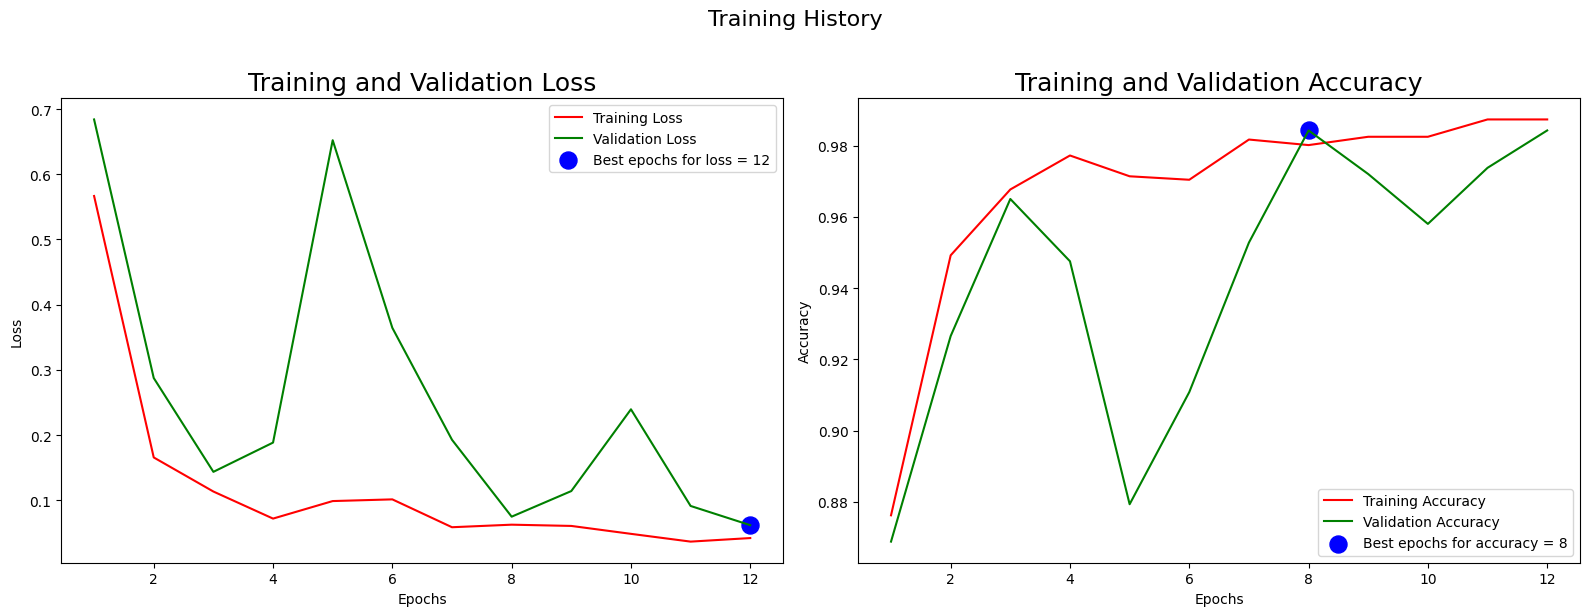

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epochs for loss = {str(index_loss + 1)}'
acc_label = f'Best epochs for accuracy = {str(index_acc + 1)}'

data = {
    'Epoch': Epochs,
    'Training Loss': train_loss,
    'Validation Loss': val_loss,
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc
}

df = pd.DataFrame(data)

csv_filename = 'densenet_training_history.csv'
df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].plot(Epochs, val_loss, 'g', label='Validation Loss')
axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
axes[0].set_title('Training and Validation Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].plot(Epochs, val_acc, 'g', label='Validation Accuracy')
axes[1].scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
axes[1].set_title('Training and Validation Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
sets_to_evaluate = [train_gen, valid_gen, test_gen]
set_names = ["Training", "Validation", "Test"]

steps = len(test_gen)

for set_name, data_gen in zip(set_names, sets_to_evaluate):
    score = model.evaluate(data_gen,
                         steps=len(data_gen),
                         verbose=1)
    loss, accuracy = score
    print(f"{set_name} Loss: {loss}")
    print(f"{set_name} Accuracy: {accuracy}")
    print('-' * 30)

322/322 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.9957 - loss: 0.0109
Training Loss: 0.012347012758255005
Training Accuracy: 0.9953307509422302
------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9843 - loss: 0.0628
Validation Loss: 0.06172836571931839
Validation Accuracy: 0.9842657446861267
------------------------------
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9937 - loss: 0.0287

2024-11-06 11:56:49.710460: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.9936 - loss: 0.0288
Test Loss: 0.035019710659980774
Test Accuracy: 0.9916094541549683
------------------------------


In [16]:
preds = model.predict(test_gen, steps=len(test_gen))
y_pred = np.argmax(preds, axis=1)
print("Number of predictions:", len(y_pred))
print("Number of test samples:", len(test_gen.classes))

82/82 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step
Number of predictions: 1311
Number of test samples: 1311


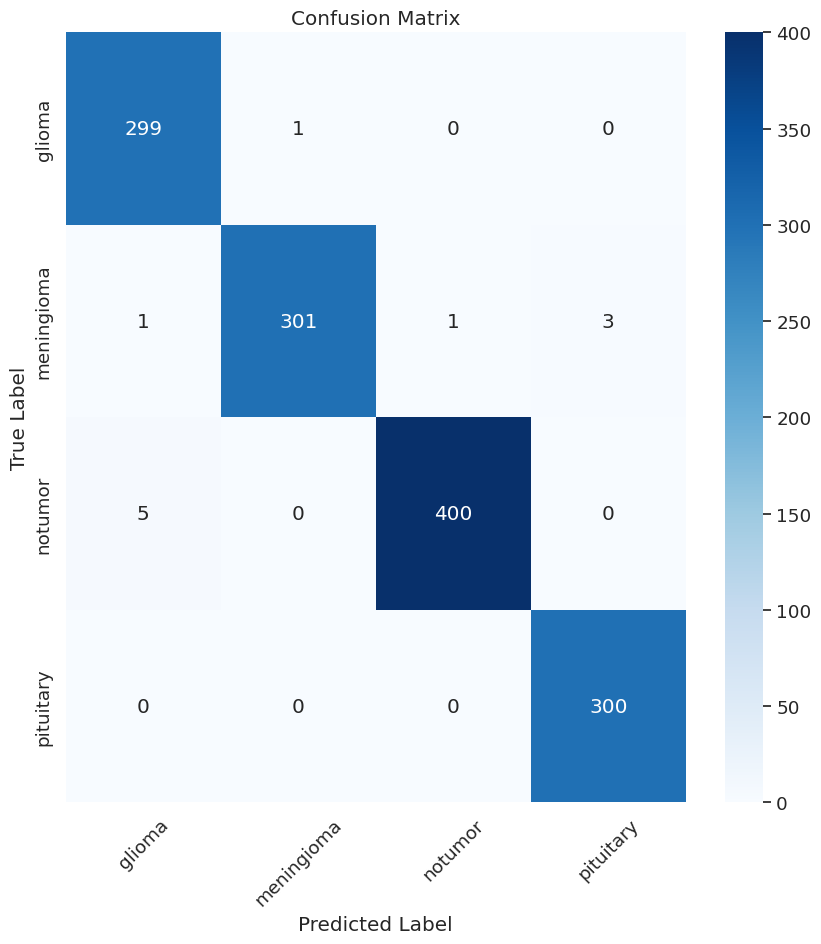

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

In [18]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       300
  meningioma       1.00      0.98      0.99       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

